# Enhancing Answer Quality in Retrieval-Augmented Generation (RAG) with Maximum Marginal Relevance (MMR)

This notebook demonstrates how integrating Maximum Marginal Relevance (MMR) into a Retrieval-Augmented Generation (RAG) pipeline can improve the quality of synthesized answers. While relevance is crucial, MMR goes a step further by ensuring the selected documents provide diverse perspectives. This can lead to more comprehensive, well-rounded answers during the final synthesis stage (L3) of RAG.

**Why MMR in a RAG Context?**  
Retrieval-Augmented Generation relies on retrieved documents (context) to guide the large language model (LLM) in crafting accurate and insightful responses. However, if the top documents are too similar—only echoing the same points—your model may miss critical nuances. MMR helps mitigate this by balancing relevance with diversity, ensuring that the retrieved set of documents covers different angles and subtopics.

**Key Concepts:**

- **Relevance:** How well a document matches the user's query.
- **Diversity:** Ensuring the returned documents are not overly similar to each other, thus offering a broader coverage of relevant information.
- **Trade-off Parameter (λ):** Controls the balance between relevance and diversity (0 ≤ λ ≤ 1)
  - λ = 1: Pure relevance ranking
  - λ = 0: Maximum diversity
  - λ = 0.5: Equal weight to both

**MMR Formula:**

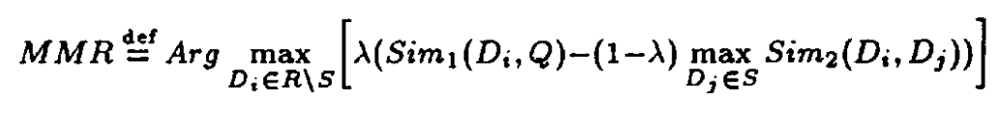


This implementation provides a foundation for more sophisticated search result diversification strategies while maintaining relevance to the original query.

In [ ]:
!pip install azure-search-documents==11.6.0b8
!pip install openai==1.45.0
!pip install python-dotenv

In [2]:
import os
import numpy as np
from typing import List, Dict, Any
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import (
    VectorizableTextQuery,
    VectorizedQuery
)
from openai import AzureOpenAI
from dotenv import load_dotenv

load_dotenv()

# Environment variables
AZURE_SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
AZURE_SEARCH_ADMIN_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_API_VERSION = "2024-10-01-preview"
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = "text-embedding-3-large"

credential = AzureKeyCredential(AZURE_SEARCH_ADMIN_KEY)
index_name = "compression-test-baseline"
search_client = SearchClient(endpoint=AZURE_SEARCH_SERVICE_ENDPOINT, index_name=index_name, credential=credential)

# Configure AzureOpenAI client (API Key auth)
client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT
)


In [3]:
# Environment variables
AZURE_SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
AZURE_SEARCH_ADMIN_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
AZURE_OPENAI_ENDPOINT: str = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY: str = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_API_VERSION: str = "2024-10-01-preview"
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME: str = "text-embedding-3-large"

credential = AzureKeyCredential(AZURE_SEARCH_ADMIN_KEY)
index_name = "compression-test-baseline"
search_client = SearchClient(endpoint=AZURE_SEARCH_SERVICE_ENDPOINT, index_name=index_name, credential=credential)


In [4]:
def generate_embeddings(text: str):
    # Generate embeddings using Azure OpenAI
    embeddings_response = client.embeddings.create(
        model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME, 
        input=text, 
        dimensions=3072
    )
    return embeddings_response.data[0].embedding


In [5]:
# Pure Vector Search
query = "What did Prime Minister Tony Blair say about climate change?"  

# Generate and print query embedding
query_embedding = generate_embeddings(query)
print("Query Embedding:")
print(f"{query_embedding[:5]}...")
print("-"*80)

# Use a VectorizedQuery with the pre-generated query embedding
vector_query = VectorizedQuery(
    vector=query_embedding, 
    k_nearest_neighbors=50, 
    fields="embedding"
)

results = search_client.search(  
    search_text=None,  
    vector_queries=[vector_query],
    top=50
)  

# Convert to a list for multiple iterations
results_list = list(results)

print(f"Number of results: {len(results_list)}")
for doc in results_list:
    print(f"title: {doc.get('title', 'No title')}")
    print(f"content: {doc.get('content', 'No content')[:200]}...")
    print(f"embedding: {doc.get('embedding', 'No embedding')[:5]}...")
    print(f"@search.score: {doc.get('@search.score', 'No score')}")
    print("-"*80)


Query Embedding:
[0.024452010169625282, 0.011633044108748436, -0.001606191392056644, -0.02325386181473732, -0.028926728293299675]...
--------------------------------------------------------------------------------
Number of results: 50
title: Blairism
content: In British politics, the term Blairism refers to the political ideology of former leader of the Labour Party and Prime Minister Tony Blair, who left both positions in 2007 to become Envoy of the Quart...
embedding: [0.0010587202, 0.023848193, -0.015566647, -0.030624002, -0.05619936]...
@search.score: 0.6392048
--------------------------------------------------------------------------------
title: Jonathan Powell (Labour adviser)
content: Jonathan Nicholas Powell (born 14 August 1956) is a British diplomat who served as the first Downing Street Chief of Staff, under British Prime Minister Tony Blair from 1995 to 2007. He was the only s...
embedding: [0.01429064, 0.002617065, -0.011580346, -0.021988673, -0.039235998]...
@search.sco

## Define the MMR Reranking Function

Now we define an MMR function that:
- Computes relevance as the cosine similarity between the query embedding and document embeddings.
- Computes diversity as the maximum cosine similarity between a candidate document and already selected documents.
- Uses `lambda_param` to balance between relevance and diversity.


In [6]:
def cosine_similarity(vec1: List[float], vec2: List[float]) -> float:
    """Calculate cosine similarity between two vectors."""
    vec1_np = np.array(vec1)
    vec2_np = np.array(vec2)
    denom = (np.linalg.norm(vec1_np) * np.linalg.norm(vec2_np) + 1e-9)
    return float(np.dot(vec1_np, vec2_np) / denom)

def mmr_reranking(
    query_embedding: List[float],
    search_results: List[Dict[str, Any]],
    lambda_param: float = 0.5,
    top_k: int = 10
) -> List[Dict[str, Any]]:
    """
    Rerank search results using Maximum Marginal Relevance (MMR) based on embeddings.
    
    Args:
        query_embedding: The embedding vector of the query.
        search_results: List of search results, each containing an "embedding" field.
        lambda_param: Trade-off parameter between relevance (to query) and diversity (0 to 1).
        top_k: Number of documents to return.
    
    Returns:
        A reranked list of documents.
    """
    if not search_results:
        print("Warning: Empty search results provided")
        return []
    
    selected = []
    remaining = search_results.copy()
    
    print(f"Starting MMR reranking with {len(remaining)} documents")
    
    while len(selected) < top_k and remaining:
        mmr_scores = {}
        
        for i, doc in enumerate(remaining):
            # Relevance to the query
            relevance_score = cosine_similarity(query_embedding, doc['embedding'])
            
            # Diversity from already selected docs
            if selected:
                similarities = [
                    cosine_similarity(doc['embedding'], sel_doc['embedding'])
                    for sel_doc in selected
                ]
                diversity_penalty = max(similarities)
            else:
                diversity_penalty = 0.0
            
            # MMR Formula
            mmr_score = lambda_param * relevance_score - (1 - lambda_param) * diversity_penalty
            mmr_scores[i] = mmr_score
            
            # Debug: Print a sample calculation for the first doc
            if len(selected) == 0 and i == 0:
                print("Sample MMR calculation for first doc:")
                print(f"  - Relevance score: {relevance_score:.4f}")
                print(f"  - Diversity penalty: {diversity_penalty:.4f}")
                print(f"  - Final MMR score: {mmr_score:.4f}")
        
        if not mmr_scores:
            break
        
        # Select document with the highest MMR score
        next_idx = max(mmr_scores.items(), key=lambda x: x[1])[0]
        selected.append(remaining[next_idx])
        remaining.pop(next_idx)
        
        print(f"Selected document {len(selected)}/{top_k} - Title: {selected[-1]['title']}")
    
    return selected

def process_vector_search_results(
    query_embedding: List[float],
    search_results: List[Dict[str, Any]],
    lambda_param: float = 0.5,
    top_k: int = 10
) -> List[Dict[str, Any]]:
    """
    Process search results with MMR reranking using embeddings.
    """
    print(f"\nProcessing {len(search_results)} search results")
    print(f"Lambda parameter: {lambda_param}")
    print(f"Requested top_k: {top_k}")
    
    # Ensure embeddings are NumPy arrays for consistency (if not already)
    for doc in search_results:
        doc["embedding"] = np.array(doc["embedding"], dtype=float)
    
    # Apply MMR reranking
    reranked_results = mmr_reranking(
        query_embedding=query_embedding,
        search_results=search_results,
        lambda_param=lambda_param,
        top_k=min(top_k, len(search_results))
    )
    
    print(f"\nReturning {len(reranked_results)} reranked results")
    return reranked_results


In [7]:
# Apply MMR Reranking
reranked_results = process_vector_search_results(
    query_embedding=query_embedding,
    search_results=results_list,
    lambda_param=0.7,  # Bias slightly towards relevance
    top_k=10
)



Processing 50 search results
Lambda parameter: 0.7
Requested top_k: 10
Starting MMR reranking with 50 documents
Sample MMR calculation for first doc:
  - Relevance score: 0.4356
  - Diversity penalty: 0.0000
  - Final MMR score: 0.3049
Selected document 1/10 - Title: Blairism
Selected document 2/10 - Title: Vicky Pope
Selected document 3/10 - Title: Earth in the Balance
Selected document 4/10 - Title: Jonathan Powell (Labour adviser)
Selected document 5/10 - Title: Singaporean response to Hurricane Katrina
Selected document 6/10 - Title: Abrupt climate change
Selected document 7/10 - Title: Frank Sartor
Selected document 8/10 - Title: Tony Abbott
Selected document 9/10 - Title: United Nations Framework Convention on Climate Change
Selected document 10/10 - Title: John Gummer

Returning 10 reranked results


In [8]:
# Compare original vs. reranked results
print("\nOriginal Top 10 Results:")
for i, doc in enumerate(results_list[:10], 1):
    print(f"{i}. {doc['title']} (score: {doc['@search.score']:.4f})")

print("\nMMR Reranked Top 10 Results:")
for i, doc in enumerate(reranked_results, 1):
    print(f"{i}. {doc['title']} (score: {doc['@search.score']:.4f})")



Original Top 10 Results:
1. Blairism (score: 0.6392)
2. Jonathan Powell (Labour adviser) (score: 0.6245)
3. Vicky Pope (score: 0.6154)
4. Tony Abbott (score: 0.6050)
5. Earth in the Balance (score: 0.6040)
6. Hadley Centre for Climate Prediction and Research (score: 0.5964)
7. Jack Straw (score: 0.5962)
8. Minister of Climate and the Environment (score: 0.5942)
9. John Gummer (score: 0.5930)
10. Abrupt climate change (score: 0.5891)

MMR Reranked Top 10 Results:
1. Blairism (score: 0.6392)
2. Vicky Pope (score: 0.6154)
3. Earth in the Balance (score: 0.6040)
4. Jonathan Powell (Labour adviser) (score: 0.6245)
5. Singaporean response to Hurricane Katrina (score: 0.5791)
6. Abrupt climate change (score: 0.5891)
7. Frank Sartor (score: 0.5891)
8. Tony Abbott (score: 0.6050)
9. United Nations Framework Convention on Climate Change (score: 0.5883)
10. John Gummer (score: 0.5930)


Note, for hybrid search and hybrid + semantic ranking, the same post-processing approach will apply.

In [9]:
def evaluate_mmr_diversity(results: List[Dict[str, Any]]) -> float:
    """Calculate average pairwise similarity as a diversity metric."""
    if len(results) <= 1:
        return 1.0
    
    similarities = []
    for i in range(len(results)):
        for j in range(i + 1, len(results)):
            sim = cosine_similarity(results[i]['embedding'], results[j]['embedding'])
            similarities.append(sim)
    
    return sum(similarities) / len(similarities)

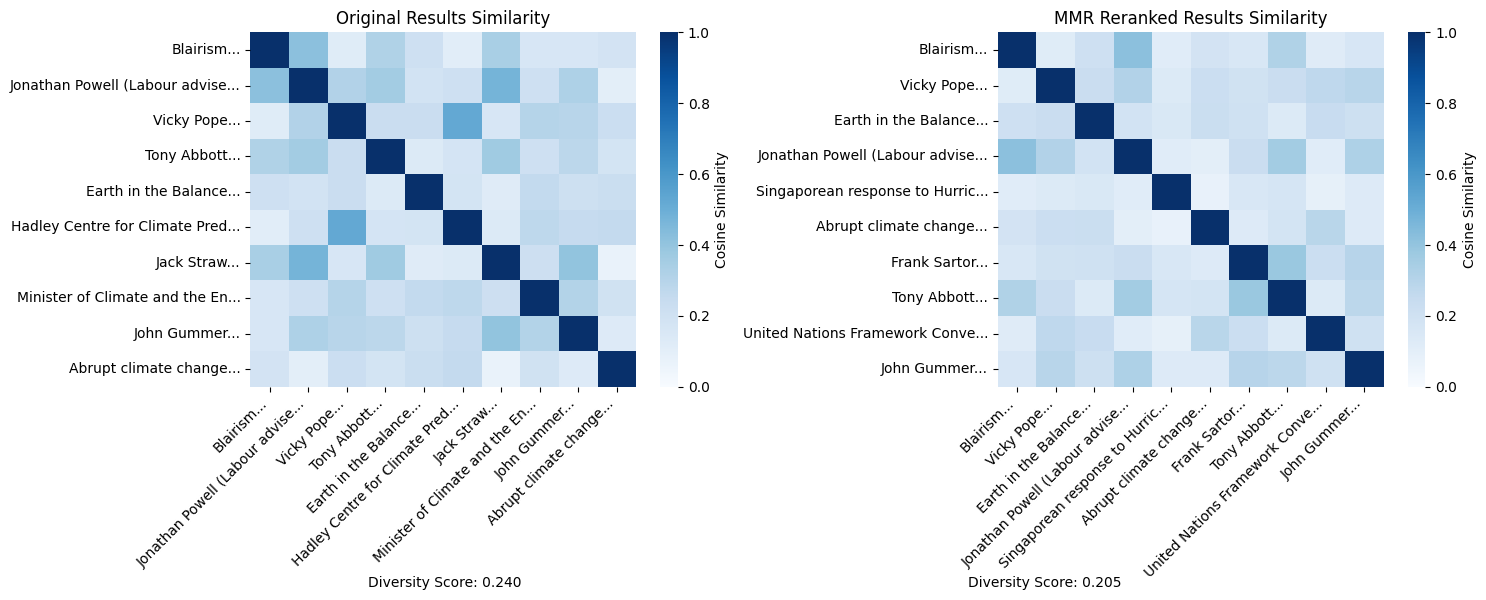


Numerical Comparison:
------------------------------------------------------------
Document                       Original Score  MMR Score      
------------------------------------------------------------
Blairism                                0.6392          0.6392
Jonathan Powell (Labour advise          0.6245          0.6154
Vicky Pope                              0.6154          0.6040
Tony Abbott                             0.6050          0.6245
Earth in the Balance                    0.6040          0.5791
Hadley Centre for Climate Pred          0.5964          0.5891
Jack Straw                              0.5962          0.5891
Minister of Climate and the En          0.5942          0.6050
John Gummer                             0.5930          0.5883
Abrupt climate change                   0.5891          0.5930


In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

def visualize_mmr_impact(original_results: list, mmr_results: list, figsize=(15, 6)):
    """
    Create heatmap visualizations comparing original and MMR-reranked results using seaborn.
    
    Args:
        original_results: List of original search results with embeddings
        mmr_results: List of MMR reranked results with embeddings
        figsize: Tuple for figure size
    """
    # Calculate similarity matrices
    def create_similarity_matrix(results):
        n = len(results)
        sim_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                sim_matrix[i, j] = cosine_similarity(
                    results[i]['embedding'],
                    results[j]['embedding']
                )
        return sim_matrix

    # Create the similarity matrices
    orig_sim_matrix = create_similarity_matrix(original_results)
    mmr_sim_matrix = create_similarity_matrix(mmr_results)
    
    # Create labels for the heatmaps
    orig_labels = [doc['title'][:30] + '...' for doc in original_results]
    mmr_labels = [doc['title'][:30] + '...' for doc in mmr_results]
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original results heatmap
    sns.heatmap(orig_sim_matrix, 
                ax=ax1,
                cmap='Blues',
                xticklabels=orig_labels,
                yticklabels=orig_labels,
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'Cosine Similarity'})
    ax1.set_title('Original Results Similarity')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
    
    # Plot MMR results heatmap
    sns.heatmap(mmr_sim_matrix,
                ax=ax2,
                cmap='Blues',
                xticklabels=mmr_labels,
                yticklabels=mmr_labels,
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'Cosine Similarity'})
    ax2.set_title('MMR Reranked Results Similarity')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_yticklabels(), rotation=0)
    
    # Calculate diversity scores (average off-diagonal similarity)
    def calculate_diversity_score(matrix):
        n = len(matrix)
        off_diag_sum = (matrix.sum() - matrix.trace()) # Sum all except diagonal
        off_diag_count = n * n - n # Number of off-diagonal elements
        return off_diag_sum / off_diag_count if off_diag_count > 0 else 0
    
    orig_diversity = calculate_diversity_score(orig_sim_matrix)
    mmr_diversity = calculate_diversity_score(mmr_sim_matrix)
    
    # Add text annotations with diversity scores
    plt.figtext(0.3, 0.02, f'Diversity Score: {orig_diversity:.3f}', 
                ha='center', va='center')
    plt.figtext(0.7, 0.02, f'Diversity Score: {mmr_diversity:.3f}', 
                ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparison
    print("\nNumerical Comparison:")
    print("-" * 60)
    print(f"{'Document':30} {'Original Score':15} {'MMR Score':15}")
    print("-" * 60)
    for orig, mmr in zip(original_results, mmr_results):
        print(f"{orig['title'][:30]:30} {orig['@search.score']:15.4f} {mmr['@search.score']:15.4f}")

# Use the visualization
visualize_mmr_impact(results_list[:10], reranked_results)

# Applying Maximum Marginal Relevance (MMR) in Retrieval-Augmented Generation (RAG)

In Retrieval-Augmented Generation (RAG) scenarios, Maximum Marginal Relevance (MMR) balances relevance and diversity among retrieved documents. This approach is vital when the context window of a language model is limited, ensuring that every retrieved document provides unique and valuable information.

**Key Benefits of MMR in RAG:**

- **Mitigating Redundancy:**  
  MMR reduces repetition by selecting documents that are both pertinent to the query and distinct from each other. This ensures the model’s limited context window isn't occupied by redundant details.

- **Enhancing Comprehensiveness:**  
  By incorporating a range of perspectives, MMR enables the creation of more thorough and nuanced responses, especially important in complex question-answering tasks.

- **Optimizing Context Utilization:**  
  When token constraints are tight, MMR ensures that each retrieved document contributes uniquely to the final answer, making full use of the available context space.

**When to Consider MMR:**

- **Limited Context Windows:**  
  If your LLM has strict token limits, MMR helps ensure a diverse and relevant set of documents, maximizing the utility of the available context.

- **Complex Information Needs:**  
  For queries that demand multifaceted answers, MMR surfaces documents covering various angles, enabling more informed and holistic responses.

- **Avoiding Redundancy:**  
  When initial retrieval results contain similar or duplicate content, MMR promotes diversity, boosting the overall quality and depth of generated outputs.

In summary, MMR is a powerful tool in RAG pipelines. It carefully curates a diverse set of relevant documents, leading to richer, more comprehensive, and ultimately more useful generated responses.
